# VAE (not nan with 100 epochs and latent space 200)

In [1]:
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras import Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-03-10 15:12:43.906243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 15:12:43.919963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 15:12:43.921838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 15:12:43.924721: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
ds = image_dataset_from_directory('/home/jupyter/data_local', label_mode=None, image_size=(448, 448), batch_size=16)

Found 2361 files belonging to 1 classes.


In [5]:
ds = ds.map(lambda x: x/255)
# ds = ds.map(lambda x: (x, x))

In [6]:
imgs = ds.as_numpy_iterator().__next__()

In [7]:
imgs.shape

(16, 448, 448, 3)

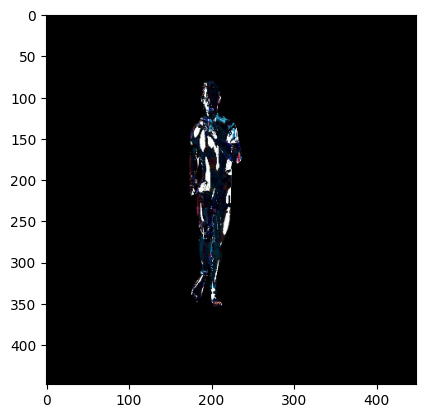

In [8]:
plt.imshow(imgs[0])


In [9]:
X_train = ds.map(lambda x : x/255).batch(16).prefetch(tf.data.AUTOTUNE)

In [10]:
from keras.layers import Lambda

In [11]:
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import Layer

In [12]:
import tensorflow as tf
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
latent_dim = 200


input_image = Input(shape=(448, 448, 3))
    
x = Conv2D(32, (3, 3), padding='same', activation="relu")(input_image)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
encoder_output = Dense(latent_dim, activation="relu")(x)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(input_image, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 224, 224, 32  0           ['conv2d[0][0]']                 
                                )                                                           

In [25]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))  
x = Dense(7*7*64, activation='tanh')(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)


    
decoder_output = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)
    
decoder = Model(inputs=latent_inputs, outputs=decoder_output, name="decoder")
decoder.summary()
    

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_5 (Dense)             (None, 3136)              630336    
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_40 (Conv2D  (None, 14, 14, 128)      73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_41 (Conv2D  (None, 14, 14, 128)      147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_42 (Conv2D  (None, 14, 14, 128)      1475

In [26]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [27]:
ds

<MapDataset element_spec=TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None)>

In [28]:
#next_images = ds.as_numpy_iterator().__next__()

In [40]:
#vae.decoder(vae.encoder(next_images[0].reshape(-1,448,448,3))[0])

In [36]:
class CallbackSaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.model.save_weights(f'/home/jupyter/model_{epoch}')

save_model = CallbackSaveModel()

In [37]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
#vae.load_weights('model_10')
vae.fit(ds, epochs=100, callbacks=[save_model])

Epoch 1/100
148/148 [==============================] - 29s 185ms/step - loss: 22087.2508 - reconstruction_loss: 21535.2305 - kl_loss: 258.1726
Epoch 2/100
148/148 [==============================] - 26s 176ms/step - loss: 20837.9208 - reconstruction_loss: 21036.4180 - kl_loss: 249.4138
Epoch 3/100
148/148 [==============================] - 26s 176ms/step - loss: 20932.8024 - reconstruction_loss: 20921.1797 - kl_loss: 247.8209
Epoch 4/100
148/148 [==============================] - 27s 179ms/step - loss: 20674.4430 - reconstruction_loss: 20814.0098 - kl_loss: 245.7506
Epoch 5/100
148/148 [==============================] - 26s 175ms/step - loss: 20701.4349 - reconstruction_loss: 20675.6348 - kl_loss: 243.8669
Epoch 6/100
148/148 [==============================] - 27s 179ms/step - loss: 20549.9501 - reconstruction_loss: 20570.7012 - kl_loss: 248.1562
Epoch 7/100
148/148 [==============================] - 26s 175ms/step - loss: 20548.9958 - reconstruction_loss: 20510.2695 - kl_loss: 246.9703

In [50]:
vae.save_weights('save_model_100epochs_200latdim')

In [51]:
#vae.load_weights('save_model_test2')load_weights

In [ ]:
#vae.fit

In [ ]:
#prediction = vae.predict(ds, verbose=0)

# Original Image

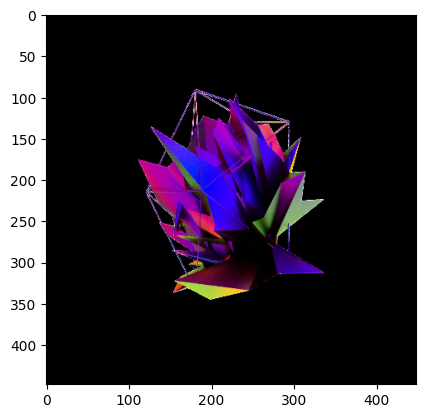

In [21]:
plt.imshow(imgs[5])

# VAE reconstructed image

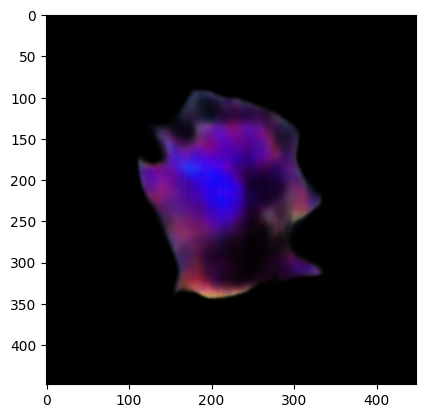

In [38]:
encoded_image = vae.encoder(imgs[5].reshape(-1,448,448,3))
decoded_image = vae.decoder(encoded_image[0])
plt.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))

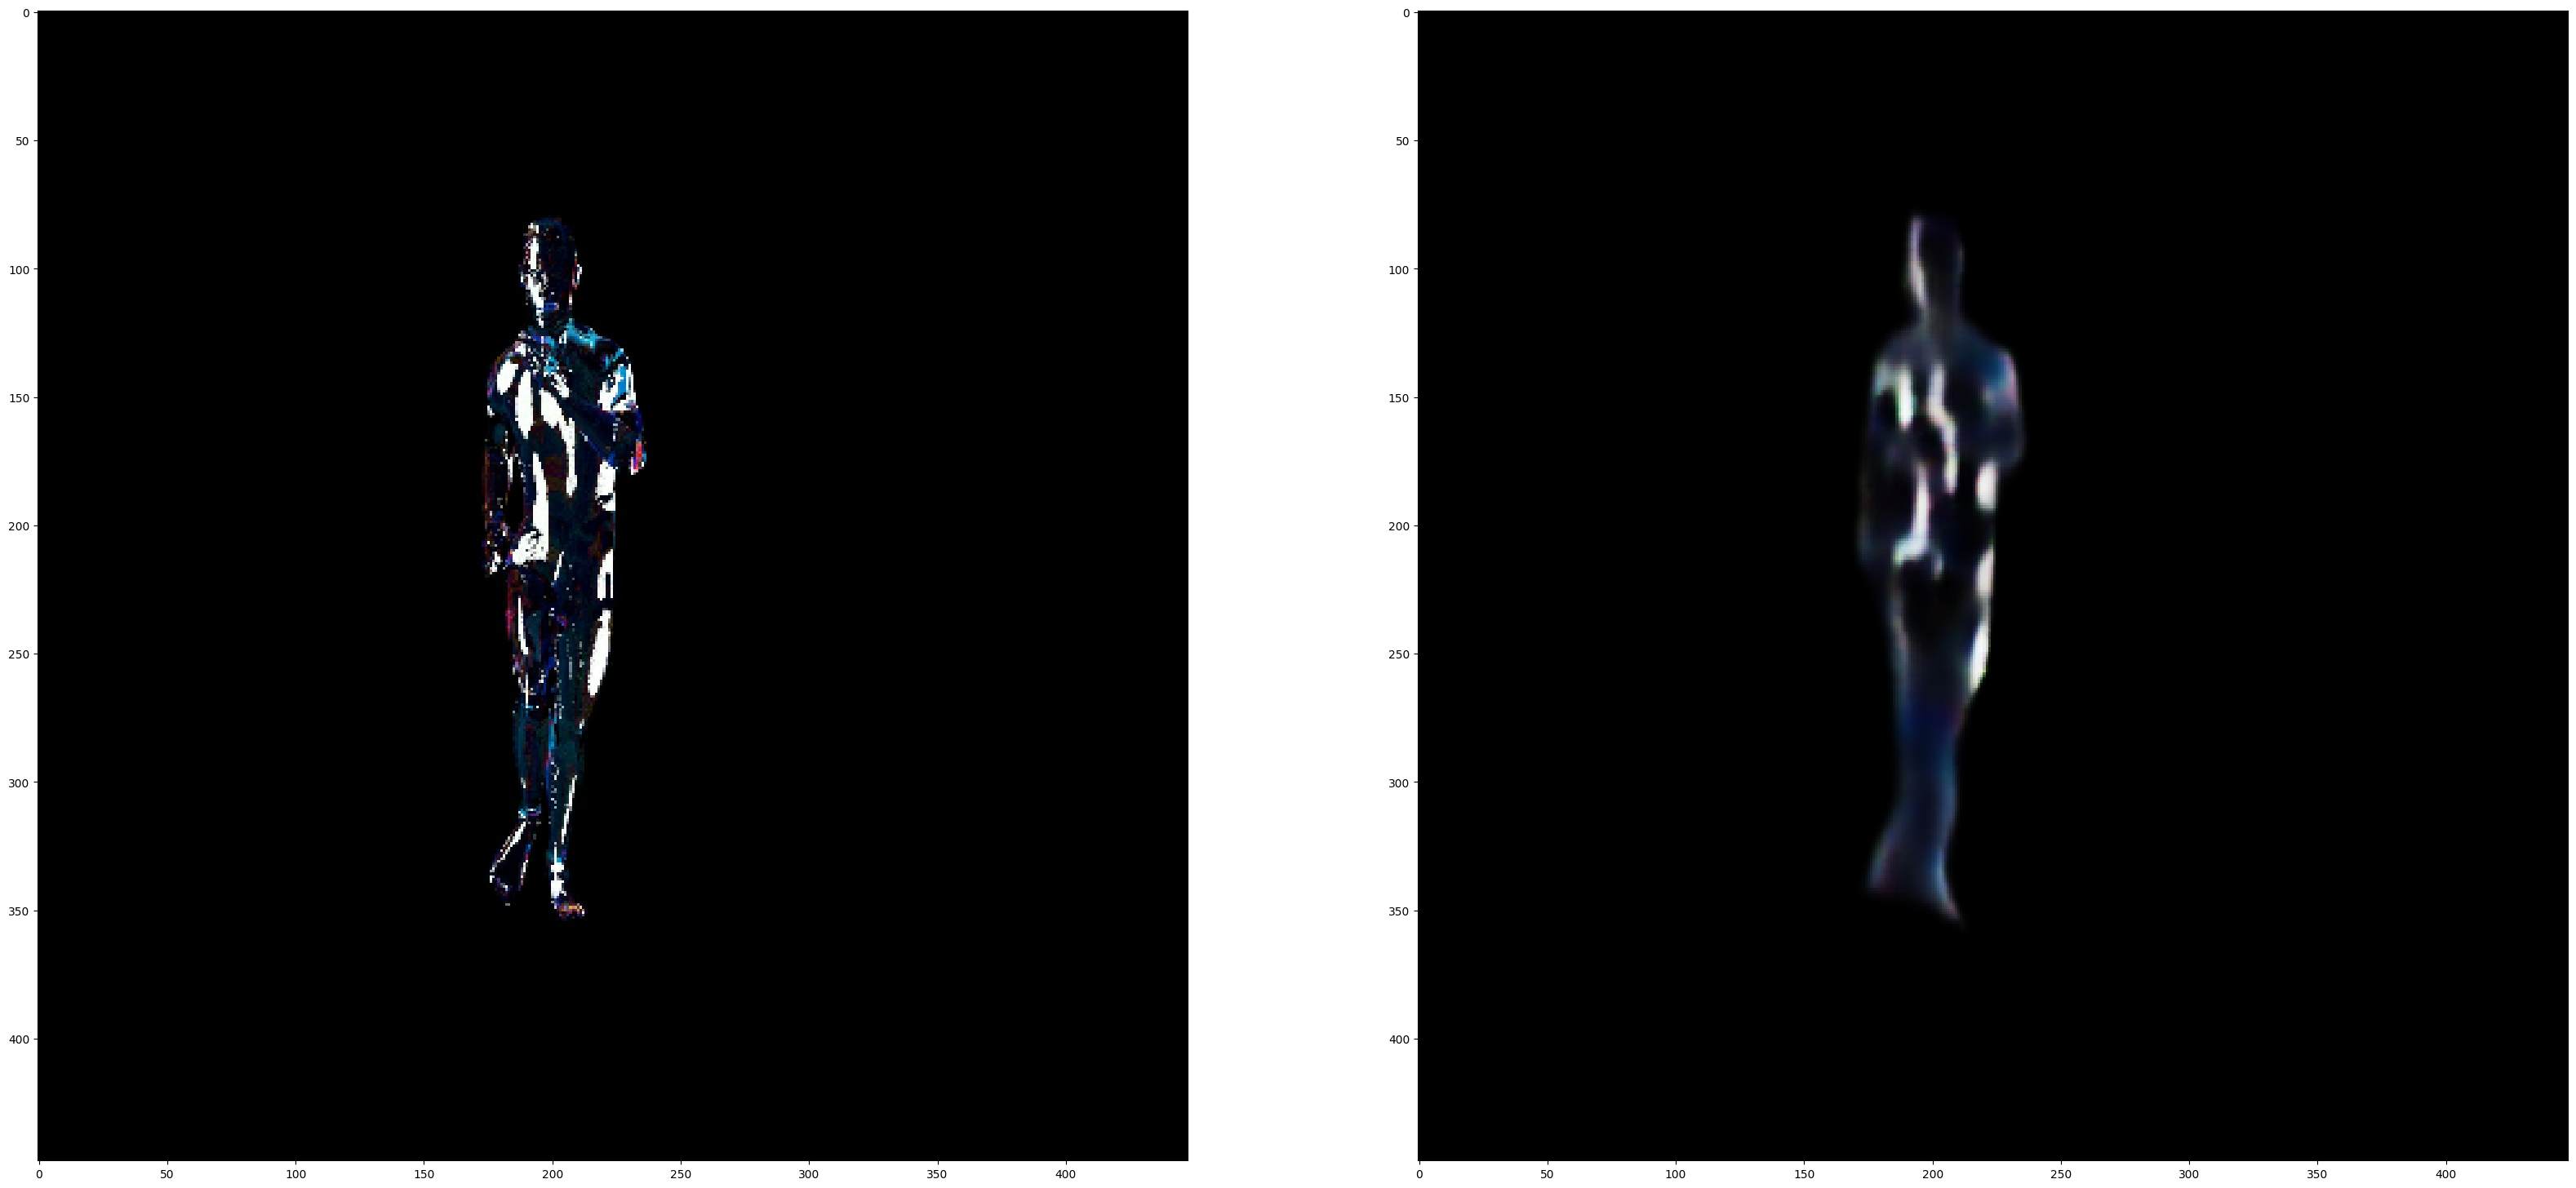

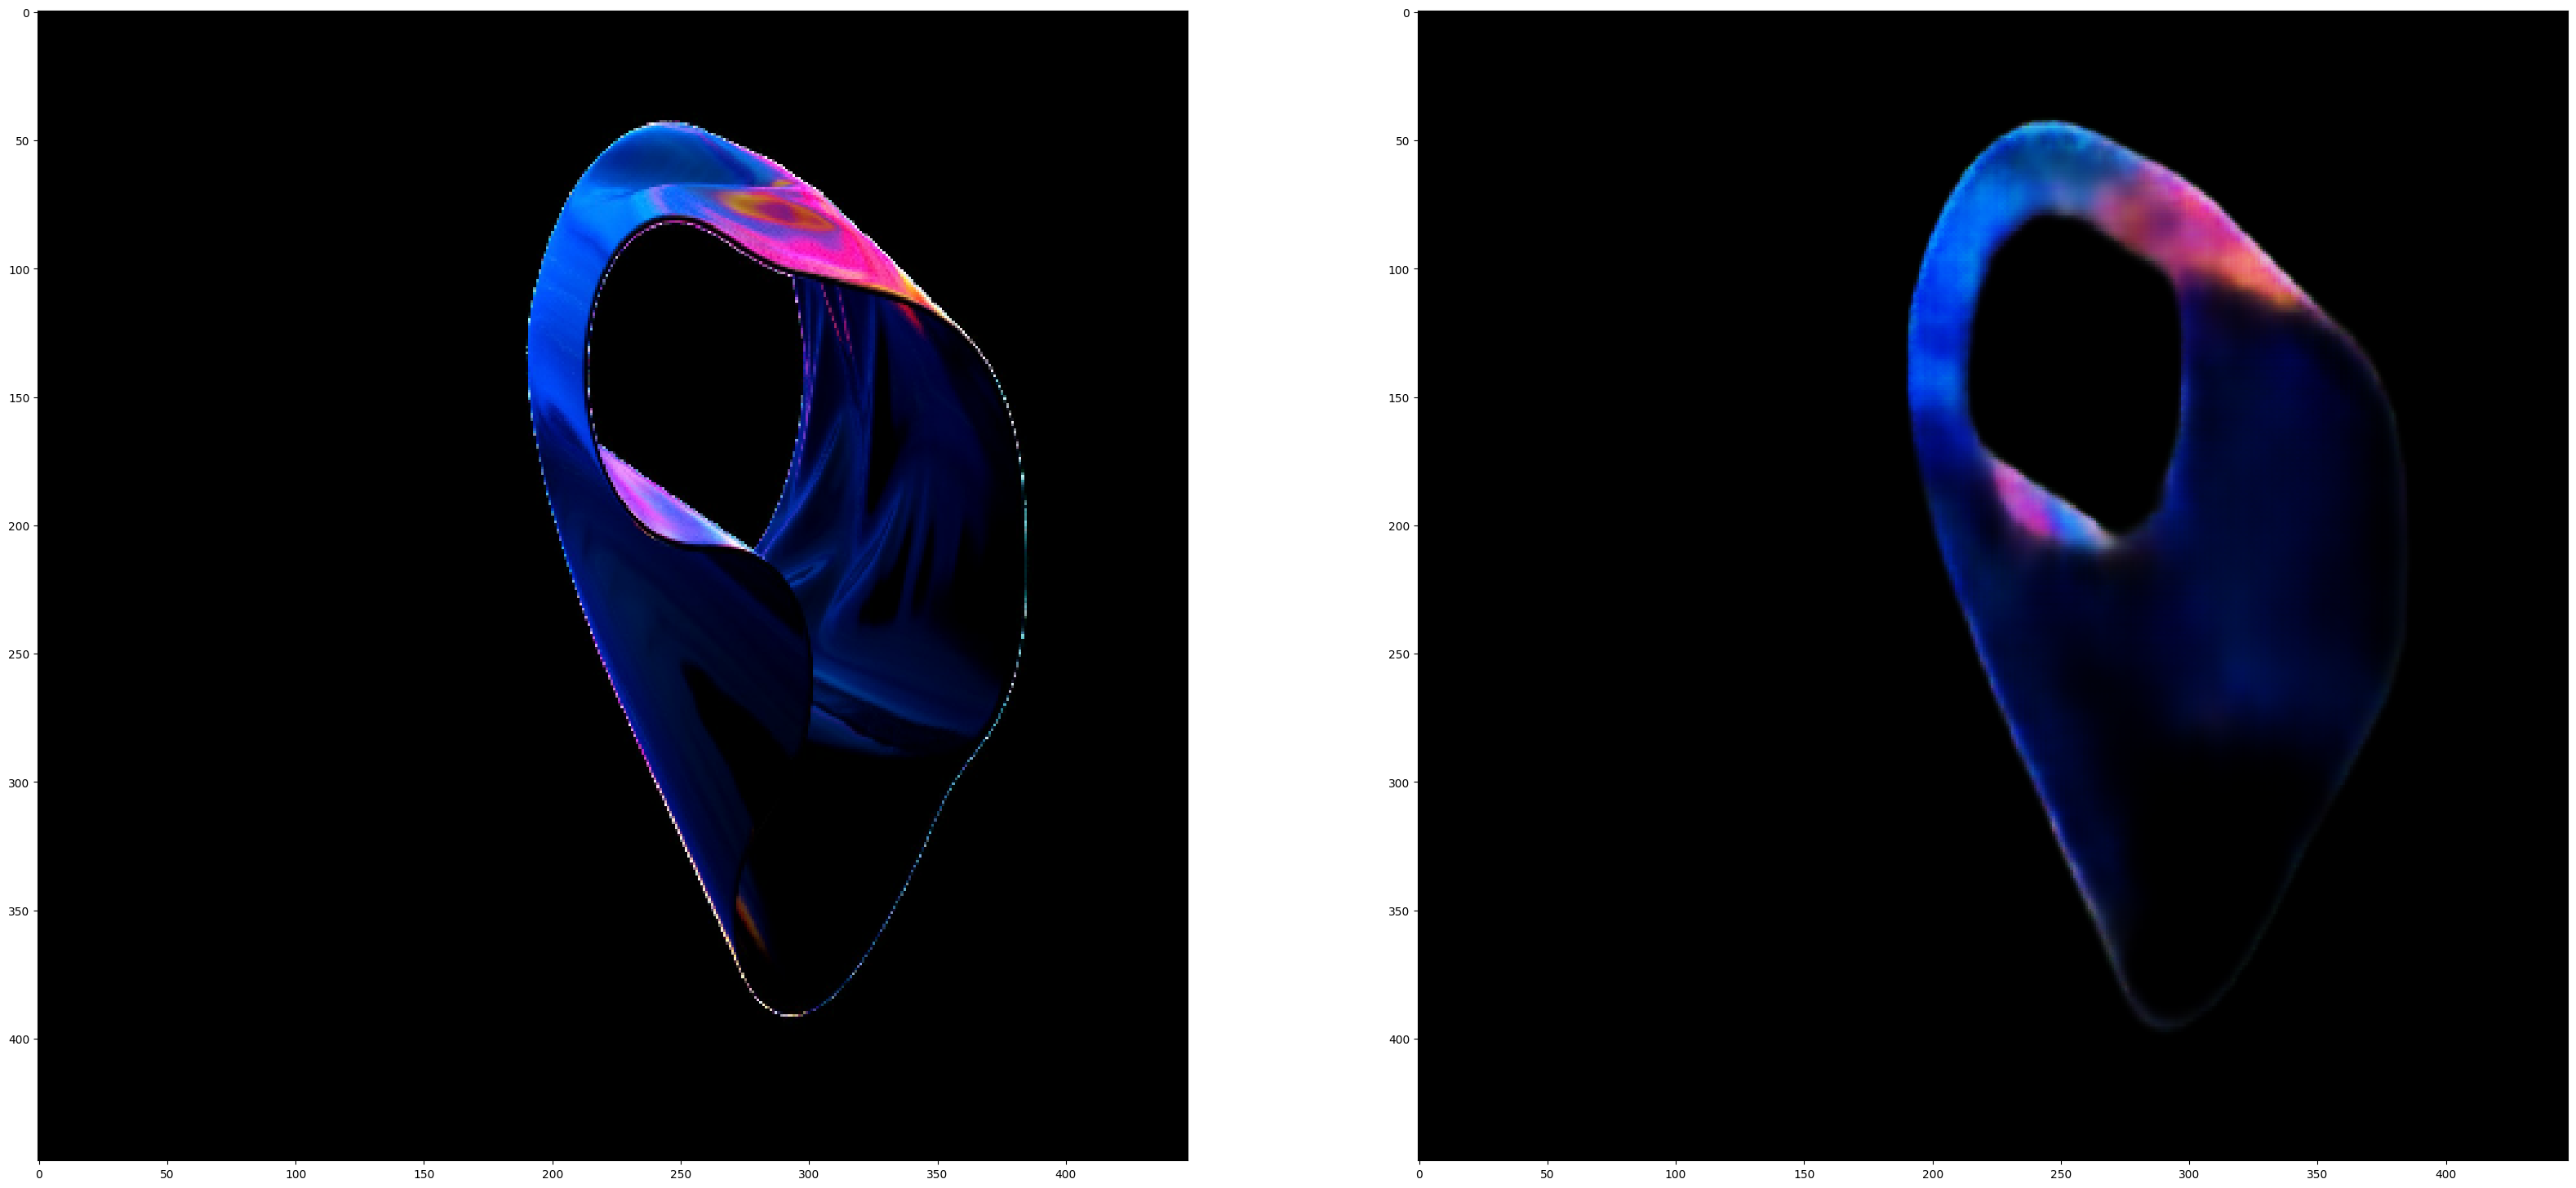

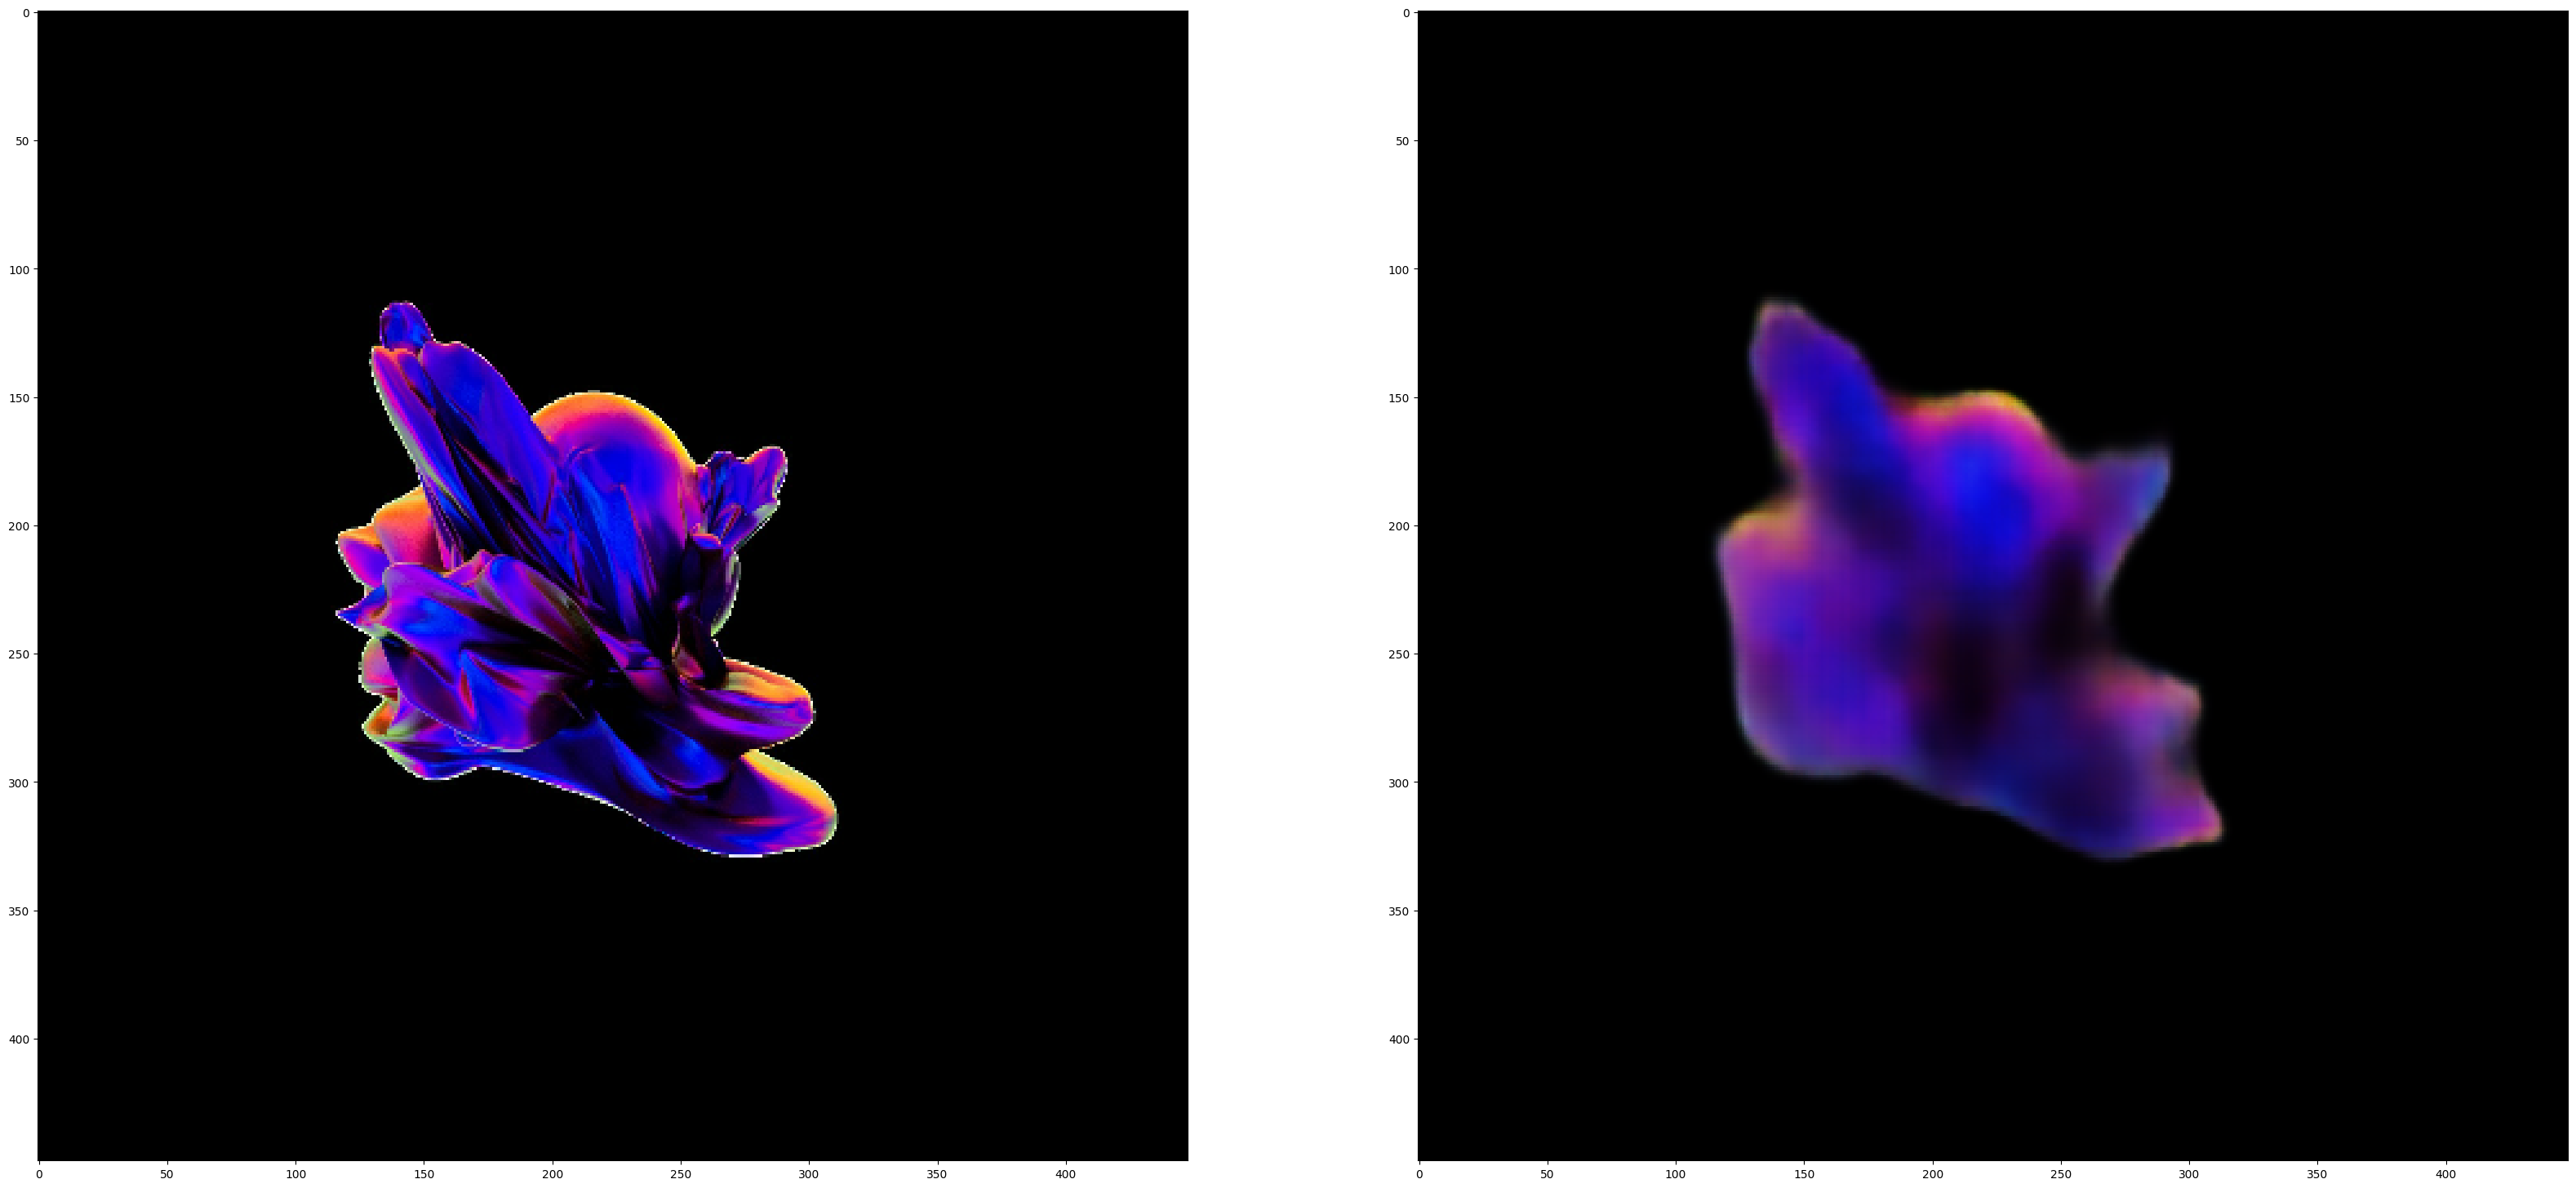

In [49]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    encoded_image = vae.encoder(imgs[i].reshape(-1,448,448,3))
    decoded_image = vae.decoder(encoded_image[0])
    ax2.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))
    ax1.imshow(imgs[i])